- Nhận user mới
- Tạo RFM cho user đó (toàn cục)
- Phân cụm user đó
- Tạo RFM cho user đó trên các item của user
- Tạo user-item matrix cho từng cụm
- Đi gợi ý sản phẩm cho user đó
- Tính F1 score

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pickle
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import coo_matrix
from collections import defaultdict
from sklearn.neighbors import NearestNeighbors
import concurrent.futures as cfutures
import matplotlib.pyplot as plt

In [2]:
weight_matrix = pd.read_csv('../../data/weight_matrix.csv', index_col=0)
weight_matrix

,Cluster 0,Cluster 1,Cluster 2
R,0.163,0.732,0.142
F,0.236,0.165,0.397
M,0.601,0.103,0.461


In [3]:
def get_weights(label: int):
    '''
        input: nhận label của cụm
        output: series chứa weights của cụm
    '''
    label = int(label)
    return weight_matrix[f'Cluster {label}'].values

In [4]:
# load mô hình kmean (hoặc fuzzy c mean) đã lưu
with open('../../data/kmean_model.pkl', 'rb') as f:
    kmean_model = pickle.load(f)
kmean_model

KMeans(n_clusters=3, random_state=12)

In [5]:
# nhận train data
train = pd.read_csv('../../data/train_processed.csv', parse_dates=[0])
rfm_train = pd.read_csv('../../data/rfm_train.csv')
# nhận test data
test = pd.read_csv('../../data/test_processed.csv', parse_dates=[0])
rfm_test = pd.read_csv('../../data/rfm_test.csv')

# Tạo RFM data (user-item)

In [6]:
recency_unit = 1
snapshot_date = dt.datetime(year=2022, month=12, day=31)

def get_recency(d):
    return (snapshot_date - d.max()).days // recency_unit

# recency: lấy ngày snapshot - ngày mua cuối
# frequency: tổng quantity
# monetary: average số tiền mua

scaler = MinMaxScaler()

def get_rfm_data(dataframe, is_train):
    dataframe = (dataframe
            .groupby(['User number', 'Product Name'])
            .agg({'DateKey': get_recency, 'Quantity': 'count', 'Regular price': 'sum'})
    )
    user_id = dataframe.index
    rfm = dataframe.values
    rfm = scaler.fit_transform(rfm)
    return pd.DataFrame(rfm, index=user_id, columns=['Recency', 'Frequency', 'Moneytary'])

In [7]:
# ui: user item
rfm_train_ui = get_rfm_data(train, True).reset_index()
rfm_test_ui = get_rfm_data(test, False).reset_index()

In [8]:
# tạo mapping giữa user number và cluster label
train_cluster_label = dict(rfm_train.groupby('User number')['Cluster Label'].mean().astype('int'))
test_cluster_label = dict(rfm_test.groupby('User number')['Cluster Label'].mean().astype('int'))

In [9]:
rfm_train_ui['Cluster Label'] = rfm_train_ui['User number'].map(train_cluster_label)
rfm_test_ui['Cluster Label'] = rfm_test_ui['User number'].map(test_cluster_label)

In [10]:
# c = w_r * c_r + w_f * c_f + w_m * c_m
list_weights_train = np.array([get_weights(label) for label in rfm_train_ui['Cluster Label']])
rfm_train_ui['Rating'] = (rfm_train_ui.loc[:, ['Recency', 'Frequency', 'Moneytary']] * list_weights_train).sum(axis=1)

list_weights_test = np.array([get_weights(label) for label in rfm_test_ui['Cluster Label']])
rfm_test_ui['Rating'] = (rfm_test_ui.loc[:, ['Recency', 'Frequency', 'Moneytary']] * list_weights_test).sum(axis=1)

In [11]:
rfm_test_ui

,User number,Product Name,Recency,Frequency,Moneytary,Cluster Label,Rating
0,101000281,Membership_1M,0.161538,0.028037,0.015943,2,0.041419
1,101000281,PT 30 session,0.584615,0.000000,0.192857,2,0.171923
2,101000670,Membership_6M,0.392308,0.000000,0.024286,2,0.066903
3,101000670,PT 30 session,0.300000,0.000000,0.192857,2,0.131507
4,101002703,Membership_1M,0.038462,0.028037,0.015943,2,0.023942
...,...,...,...,...,...,...,...
626,105002780,PT 50 session,0.069231,0.000000,0.285714,2,0.141545
627,105002784,Membership_6M,0.100000,0.000000,0.024286,2,0.025396
628,105002784,PT 30 session,0.076923,0.000000,0.192857,2,0.099830
629,105002844,Membership_6M,0.053846,0.000000,0.024286,2,0.018842


# Revert moneytary

In [12]:
sum_value = rfm_test_ui[['Recency', 'Frequency', 'Moneytary']].sum()
sum_value = sum_value.values.reshape(1, -1)
sum_value

array([[295.84615385,  22.6728972 ,  70.55098571]])

In [13]:
scaler = pickle.load(open('scaler.pkl', 'rb'))
scaler

MinMaxScaler()

In [14]:
sum_sale = scaler.inverse_transform(sum_value)[0][-1]
print("Sum test sale:", sum_sale)

Sum test sale: 4938568999.999999


In [48]:
def get_moneytary_of_user(user_number, list_product):
    datum = rfm_test_ui.query(f"`User number` == {user_number} and `Product Name` in {list_product}")
    money = datum[['Recency', 'Frequency', 'Moneytary']].sum().values.reshape(1, -1)
    return scaler.inverse_transform(money)[0][-1]

# Build CF

In [15]:
class CF:
    def __init__(self, rfm, k = 5):
        self.rfm = rfm
        self.k = k
        self.list_mae = []
        self.cluster_label_dict = {}
        self.make_ui(self.rfm)
        
    def add(self, rfm):
        self.rfm = pd.concat([self.rfm, rfm])
        self.make_ui(self.rfm)
        
    def make_ui(self, rfm):
        self.items = rfm['Product Name'].unique()
        self.size_item = self.items.shape[0]
        self.item_id = np.arange(self.size_item)
        self.map_item = dict(list(zip(self.items, self.item_id)))
        
        # tạo nơi chứa dữ liệu cho từng cụm
        self.cluster_data = defaultdict(dict)
        
        # lặp qua tất cả cụm
        for label in rfm['Cluster Label'].unique():
            
            # lấy data cho từng cụm
            cluster_rfm = rfm[rfm['Cluster Label'] == label]
            
            # lấy danh sách user duy nhất
            users = cluster_rfm['User number'].unique()
            
            users_dict = {user: label for user in users}
            self.cluster_label_dict.update(users_dict)
            
            # tạo biến lưu kích cỡ user
            size_user = users.shape[0]
            
            # tạo index cho user
            user_id = np.arange(size_user)
            
            # tạo một ánh xạ giữa user và index
            map_user = dict(list(zip(users, user_id)))
            
            # lấy danh sách index của user và item
            user_indices = cluster_rfm['User number'].map(map_user)
            item_indices = cluster_rfm['Product Name'].map(self.map_item)
            
            ui_matrix = coo_matrix(
                (cluster_rfm.Rating, (user_indices, item_indices)),
                shape=(size_user, self.size_item)
            ).tocsr().toarray()
            
            # pearson correlation
            sim = pd.DataFrame(ui_matrix).T.corr().values
            
            self.cluster_data[label]['rfm'] = cluster_rfm
            self.cluster_data[label]['user_id'] = user_id
            self.cluster_data[label]['map_user'] = map_user
            self.cluster_data[label]['ui_matrix'] = ui_matrix
            self.cluster_data[label]['sim'] = sim
    
    def recommend(self, user_number):
        '''
            nhận vào một user number từ tập dữ liệu test
            sau đó trả về danh sách những sản phẩm được khuyến nghị
        '''
        # tìm cụm mà user đó thuộc về
        cluster_label = self.cluster_label_dict[user_number]
                
        cluster_data = self.cluster_data[cluster_label]
        rfm_data = cluster_data['rfm']
        map_user = cluster_data['map_user']
        user_item = cluster_data['ui_matrix']
        similarity_matrix = cluster_data['sim']
        
        # tìm index của user theo id
        user_idx = map_user[user_number]

        list_product_recommendation = []
        # lặp qua tất cả sản phẩm hiện có
        for product_name, product_idx in self.map_item.items():
            bought = False

            # tìm tất cả user đã mua sản phẩm đó
            user_rated_product = rfm_data.query(f'`Product Name` == "{product_name}"')['User number'].values
            user_rated_product = np.array([map_user[i] for i in user_rated_product])

            if user_idx in user_rated_product:
                bought = True
            
            # khi user chưa mua thì phải 
            # tính rating dự đoán
            if user_rated_product.shape[0] > 0: 
                # tìm các hệ số tương quan giữa user mong muốn và tất cả user đã rate
                
                sim = similarity_matrix[user_idx, user_rated_product]
                k_sim = np.argsort(sim)[-self.k:] # chỉ lấy k user tương tự user hiện tại
                # phần k-nearest neighbors

                sim = sim[k_sim]
                user_rated_product = user_rated_product[k_sim]

                # sim = sim[sim < 1] # loại bỏ giá trị có tương quan là 1, vì nó tương quan với chính nó
                rating = user_item[user_rated_product, product_idx] # lấy list rating của những user đã rate

                mean_rating = user_item[user_rated_product].mean(axis=1)

                # tính hệ số rating dự đoán, tổng trọng số giữa rating và độ tương quan
                r = user_item[user_idx].mean() + (sim * (rating - mean_rating)).sum() / (sim.sum() + 1e-8)
            else: # chưa có ai mua sản phẩm này trong cùng một cụm cả
                r = 0
            
            if bought:
                # chỉ tính mae trên những rating có sẵn
                pred_value = r
                true_value = user_item[user_idx, product_idx]
                self.list_mae = [abs(pred_value - true_value)]

            # đưa vào tuple (product id, rating, bought, is recommend) -> tí nữa sắp xếp giảm dần
            list_product_recommendation.append((product_name, r, bought, r > 0))

        # sắp xếp giảm dần theo rating dự đoán
        list_product_recommendation = sorted(list_product_recommendation, key=lambda x: x[1], reverse=True)
        
        limit = 10 # 
        list_product_recommendation = list_product_recommendation[:limit]
        
        return list_product_recommendation, cluster_label

    
    def cal_mae(self, list_user_number):
        self.list_mae = []
        with cfutures.ThreadPoolExecutor() as exe:
            exe.map(self.recommend, list_user_number)
        mae = np.array(self.list_mae)
        return mae.sum() / mae.shape[0]
        
    def __repr__(self):
        return '<CF>'.format(self)

# Find best K for Collaborative Filtering

In [16]:
list_test_user = test['User number'].unique().tolist()

In [17]:
%%time

list_k = [20, 30, 50, 60]
list_mae = []

random_100_user = np.random.choice(list_test_user, size=100)

for k in list_k:
    cf = CF(rfm_train_ui, k=k)
    cf.add(rfm_test_ui)
    mae = cf.cal_mae(random_100_user)
    list_mae.append(mae)
    print(k, mae)

20 0.008388339035680148
30 0.015630187762892628
50 0.009381714882038261
60 0.00948176855716057
Wall time: 47.5 s


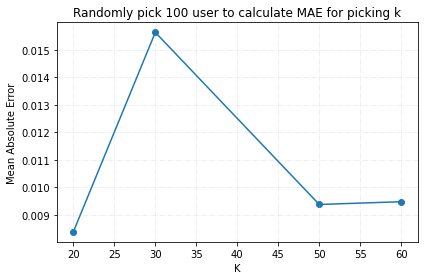

In [18]:
fig, ax = plt.subplots()
ax.plot(list_k, list_mae)
ax.scatter(list_k, list_mae)
ax.grid(True, alpha=.25, ls='-.')
ax.set_ylabel("Mean Absolute Error")
ax.set_xlabel("K")
ax.set_title("Randomly pick 100 user to calculate MAE for picking k")
fig.tight_layout()
plt.savefig('picking_k.jpg')
plt.show()

In [19]:
best_k = list_k[np.argmin(list_mae)]
best_k

20

In [20]:
%%time

# khởi tạo đối tượng CF (collaborative filtering)
# với bộ dữ liệu train
cf = CF(rfm_train_ui, k=best_k)

# thêm tập dữ liệu test vào để chuẩn bị test
cf.add(rfm_test_ui)

Wall time: 7.41 s


In [21]:
ui_matrix = cf.cluster_data[0]['ui_matrix']
map_user = cf.cluster_data[0]['map_user']

items = list(cf.map_item.keys())
users = list(map_user.keys())
pd.DataFrame(ui_matrix, columns=items, index=users).replace(0, np.nan).to_csv('user_item.csv')

In [50]:
def cal_confusion_matrix(user, out):
    data = pd.DataFrame(out, columns=['name', 'rating', 'bought', 'recommended'])
    tp = data.query('bought == 1 and recommended == 1').shape[0]
    fp = data.query('bought == 0 and recommended == 1').shape[0]
    fn = data.query('bought == 1 and recommended == 0').shape[0]
    tn = data.query('bought == 0 and recommended == 0').shape[0]
    
    list_product = data.query('bought == 1 and recommended == 1')['name'].values.tolist()
    
    moneytary = get_moneytary_of_user(user, list_product)
    return tp, fp, fn, tn, moneytary

# Calculate F1 Score

In [51]:
%%time

def cal(user):
    out, cluster_label = cf.recommend(user)
    return cluster_label, cal_confusion_matrix(user, out)

with cfutures.ThreadPoolExecutor() as exe:
    list_confusion_matrix = list(exe.map(cal, list_test_user))

Wall time: 20 s


In [52]:
# cộng tất cả tn, fp, fn, tn của tất cả user với nhau
metrics = defaultdict(lambda : defaultdict(int))
for cluster_label, (_tp, _fp, _fn, _tn, moneytary) in list_confusion_matrix:
    metrics[cluster_label]['tp'] += _tp
    metrics[cluster_label]['fp'] += _fp
    metrics[cluster_label]['fn'] += _fn
    metrics[cluster_label]['tn'] += _tn
    metrics[cluster_label]['moneytary'] += moneytary        

In [53]:
metrics

defaultdict(<function __main__.<lambda>()>,
            {2: defaultdict(int,
                         {'tp': 302,
                          'fp': 2088,
                          'fn': 0,
                          'tn': 0,
                          'moneytary': 4141184000.0})})

In [26]:
for label, data in metrics.items():
    precision = data['tp'] / (data['tp'] + data['fp'])
    recall = data['tp'] / (data['tp'] + data['fn'])
    f1_score = (2 * precision * recall) / (precision + recall)
    metrics[label]['precision'] = precision
    metrics[label]['recall'] = recall
    metrics[label]['f1_score'] = f1_score

In [54]:
for label, data in metrics.items():
    print("Label:", label)
    print("Precision:", data['precision'])
    print("Recall:", data['recall'])
    print("F1:", data['f1_score'])
    print("="*50)

Label: 2
Precision: 0
Recall: 0
F1: 0


In [55]:
def get_recommendation(user_number):
    out, label = cf.recommend(user_number)
    data = pd.DataFrame(out, columns=['name', 'rating', 'bought', 'recommended'])
    return data

In [56]:
%%time

# chỗ này đưa ra danh sách dự đoán sản phẩm
# cho một user number nào đó lấy từ tập test
user_number = 101000391
get_recommendation(user_number)

Wall time: 109 ms


,name,rating,bought,recommended
0,PT 10 session,0.295426,False,True
1,Membership_13M,0.173922,False,True
2,Membership_7M,0.171617,False,True
3,Membership_12M,0.141968,False,True
4,JoiningFee_2M,0.103572,False,True
5,Membership_6M,0.094466,False,True
6,Membership_1D,0.081647,False,True
7,Lock,0.081466,False,True
8,Membership_1M,0.079453,True,True
9,Shaker,0.059695,False,True
